# Calculate Archie Water Saturations after Fine-Tuning Electrical Properties to Pickett and Buckles Plots using Python's Panel Library

Beta software. Please consider this work in progress. 

While experimenting with interactive python tools for our next GitHub repository, we came upon a python library called panel. Panel appears to provide the type of interaction that we need for our petrophysical analysis. This simple example represents work in progress, but we have placed this python tool this GitHub repository for others to try use and hopefully improve upon what we have so far.

In the animated example below, we are calculating Archie water saturations from a Costa Field well. The panel tool shown below calculates a new water saturation as you vary the electrical properties (m&n) or Rw. The tool provides instantaneous results that can be seen in from the changes in the saturation lines in the Pickett plot as well as the depth plot BVW results.

Panel provides the type of interactivity that allows the user to fine-tune their analysis using the Pickett and Buckles plots. The Pickett plot is fundamental to our calculation of water saturations from conventional logs, and this tool will allow you to build a better understanding of your data and allow you to develop a better feel for the sensitivity of each parameter used in the Archie water saturation calculation.

In this example well, the interval at the bottom of the depth plot appears to be wet. However, is this interval at 100% Sw or does it contain some residual oil? We do not have residual fluid saturations from core to allow us to determine if there is any residual oil saturations, so we have made the assumption that the intervals is 100% water saturated for now. In this example we adjust the m and Rw to give us 100% water saturations from logs for this lower interval. You can then adjust the n to give you the expected BVW from the Buckles plot. 

>---
>
>![Panel_log](pickett_log_sats2.gif)
>
>---

**Load python libraries:**

In [1]:
import numpy as np
import pandas as pd
import datashader as ds
import panel as pn
pn.extension()

pn.extension(sizing_mode="stretch_width")

from numba import jit
from datashader import transfer_functions as tf
from colorcet import palette_n


import math
import openpyxl
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import lasio

%matplotlib inline




## Load las file with Lasio:

In [2]:
las = lasio.read("./HW-10.las");elev_meas_ref = 453

In [3]:
las.keys()

['DEPT',
 'GR',
 'RHOB',
 'NPHI',
 'DT',
 'PHIE',
 'RT',
 'SW',
 'SO',
 'CORE_POR',
 'CORE_PERM']

In [4]:
for item in las.well:
    print(f"{item.descr} ({item.mnemonic}): {item.value}")

 (STRT): 8150.0
 (STOP): 8630.0
 (STEP): 0.5
 (NULL): -999.25
COMPANY (COMP): 
WELL (WELL): HW-10
FIELD (FLD): COSTA
LOCATION (LOC): 
SERVICE COMPANY (SRVC): 
ss} (DATE): 2018-02-06 14:55:39   : Log Export Date {yyyy-MM-dd HH:mm
PROVINCE (PROV): 
UNIQUE WELL ID (UWI): HW-10
API NUMBER (API): 


## Create DataFrame from las file:

In [5]:
df_log = las.df()
df_log.head()

,GR,RHOB,NPHI,DT,PHIE,RT,SW,SO,CORE_POR,CORE_PERM
DEPT,,,,,,,,,,
8440.0,31.66,2.73,0.07,NaN,0.0,17.62,NaN,NaN,NaN,NaN
8440.5,30.61,2.73,0.06,NaN,0.0,19.01,NaN,NaN,NaN,NaN
8441.0,29.37,2.72,0.06,NaN,0.0,20.33,NaN,NaN,NaN,NaN
8441.5,28.05,2.73,0.05,NaN,0.0,21.58,NaN,NaN,NaN,NaN
8442.0,27.10,2.73,0.05,NaN,0.0,22.79,NaN,NaN,NaN,NaN


## Calculate individual log curves for analysis:

the bvw curve being calclated below is just to create the curve bvw.

In [6]:
m = 1.8          # Electrical property m initial start
n = 1.8          # Electrical property n initial start
rw = 0.012     # Formation brine resistivity

gd = 2.71  # Matrix Density 
fd = 1.1   # Fluid Densitr

# Calculate Density Porosity
rhob = np.array(df_log['RHOB'])
porarray = []
for k in range(0,len(df_log),1):
    porarray.append((gd-rhob[k])/(gd-fd))


ild=np.array(df_log['RT'])
y=np.array(las['DEPT'])
bvw=np.array(df_log['PHIE'])
swt=np.array(df_log['SW'])


### Define Primary Plot file:

In [7]:
def Plot_sw(m,n,rw):
    
    fig, (ax2, ax1,ax3) = plt.subplots(3, 1)
    fig.suptitle('Saturations from Logs',color='blue' , fontsize=18)
    fig.subplots_adjust(top=0.95,wspace=0.1, hspace =.15)
    fig.set_figheight(15)
    fig.set_figwidth(6)
    
    # Depth Plot 
    ax1.plot(porarray, y,'-r', lw=1)#, label= 'PHIT')
    ax1.plot(bvw, y,'-k', lw=1)#, label= 'BVW')
    ax1.set_xlabel("Bulk Volume Calculations",color='blue')
    ax1.set_ylabel("Depth",color='blue')
    ax1.set_xlim(0.5, 0.0)
    ax1.set_ylim(max(y), min(y))
    ax1.fill_betweenx(y,porarray,bvw, color='green', label= 'BVO')
    ax1.fill_betweenx(y,bvw,0, color='cyan', label= 'BVW')
    ax1.legend()
    ax1.grid()

    
    # Pickett Plot
    ax2.loglog(ild,porarray, 'ro')
    ax2.set_xlim(0.01,1000)
    ax2.set_ylim(0.01,1)
    ax2.set_ylabel('PHIT [v/v]', color = 'blue')
    ax2.set_xlabel('ILD [ohmm]', color = 'blue')
    ax2.grid()
    ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))

    #calculate the saturation lines
    sw_plot=(1.0,0.8,0.6,0.4,0.2)
    phit_plot=(0.01,1)
    rt_plot=np.zeros((len(sw_plot),len(phit_plot)))

    for i in range (0,len(sw_plot)):
        for j in range (0,len(phit_plot)):
            rt_result=((rw)/(sw_plot[i]**n)/(phit_plot[j]**m))
            rt_plot[i,j]=rt_result      
    for i in range(0,len(sw_plot)):
        ax2.plot(rt_plot[i],phit_plot, linewidth=2, label='SW '+str(int(sw_plot[i]*100))+'%')
        ax2.legend (loc='best')
    ax2.grid(True, which='both',ls='-' ,color='gray')

    # Buckles Plot
    #ax3.plot(swt, porarray, 'bo')
    #ax3.scatter(swt, porarray, bvw,c=bvw,  cmap="rainbow")
    ax3.scatter(swt, porarray,    marker='d',c=bvw,  cmap="gist_rainbow")
    ax3.set_xlim(0.0,1.0) 
    ax3.set_ylim(0.0,0.35)
    ax3.set_ylabel('PHIT [v/v]', color = 'blue')
    ax3.set_xlabel('Swt [v/v]' , color = 'blue')
    ax3.grid()

    
    return fig



## Explore Panel's interactive widgets:

We use interactive Sliders to vary m, n and Rw to calculate an Archie water saturation. The interactive nature of these Panel widgets allows the user to see their instantaneous calculations of BVW and the lines on the Pickett Plot and the parameters are varied. 

---
**There are an extra set of plots that at the bottom of this cell that are not interactive. We are trying to remove these extra plots, but in this version this is a bug to be fixed.** 

/var/folders/lf/9hqr0q153ls52s9btzjc56080000gp/T/ipykernel_77601/847072530.py:14: RuntimeWarning: invalid value encountered in double_scalars
  BVW = PHIT*((1/PHIT**m) * (rw/ILD) )**(1/n)


Row(sizing_mode='stretch_width')
    [0] Column(sizing_mode='fixed', width=400)
        [0] PNG(str, sizing_mode='stretch_width')
        [1] Markdown(str, sizing_mode='stretch_width')
        [2] Column(sizing_mode='stretch_width')
            [0] FloatSlider(end=3.0, format=PrintfTickFormatter(id='10..., name="Cementation E..., sizing_mode='stretch_width', start=1.0, step=0.05, value=1.8)
            [1] FloatSlider(end=3.0, format=PrintfTickFormatter(id='10..., name="Saturation Exponent '..., sizing_mode='stretch_width', start=1.0, step=0.05, value=1.8)
            [2] FloatSlider(end=0.05, format=PrintfTickFormatter(id='10..., name='Rw = ', sizing_mode='stretch_width', start=0.01, step=0.001, value=0.012)
    [1] VSpacer(width=10)
    [2] Row(sizing_mode='stretch_width')
        [0] Matplotlib(Figure, name='interactive00105', sizing_mode='stretch_width')
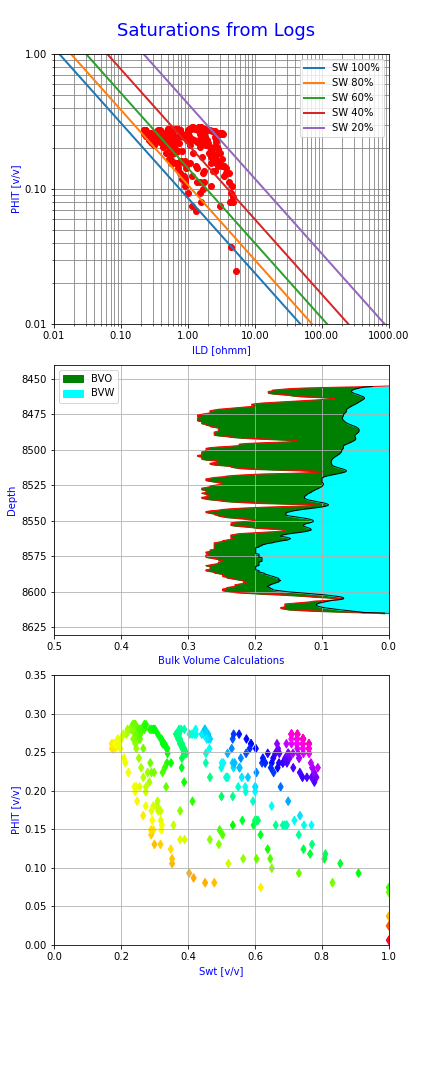
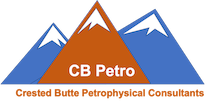

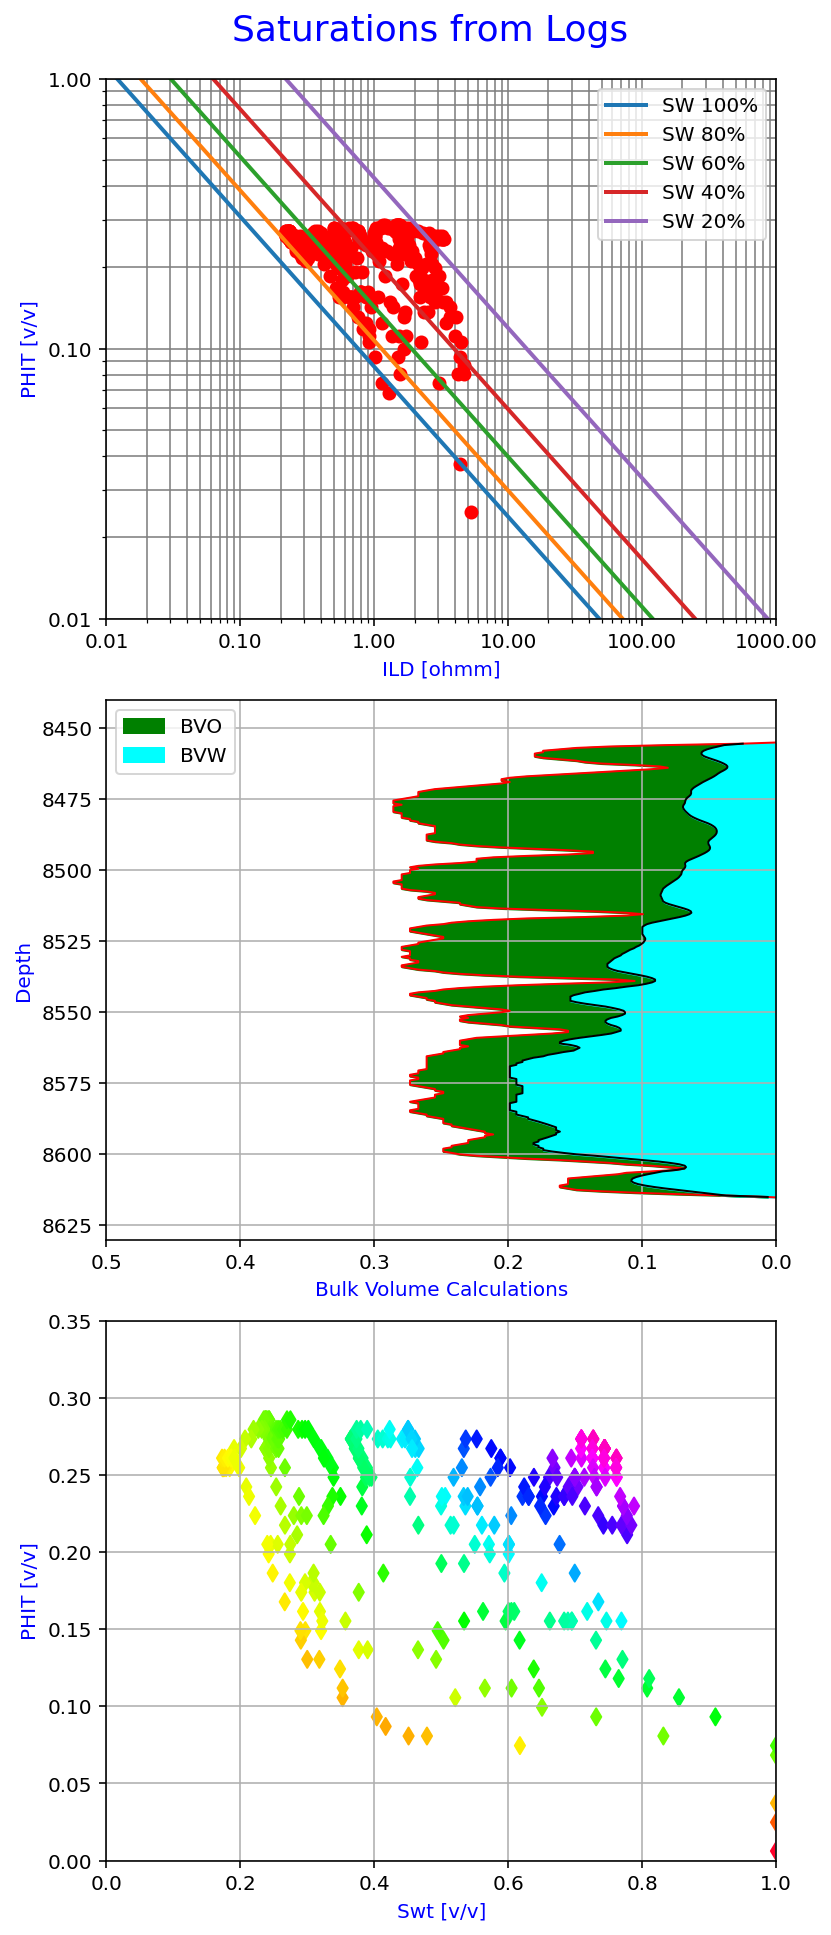

In [8]:
import matplotlib.ticker as ticker
from bokeh.models.formatters import PrintfTickFormatter


def calc_bvw(m, n,rw):
    for k in range(0,len(df_log) ,1):  

        ILD     = ild[k]
        PHIT    = porarray[k]

        # =================================================================================
        #       Saturation Calculations
        # =================================================================================
        BVW = PHIT*((1/PHIT**m) * (rw/ILD) )**(1/n)

        if BVW > PHIT:
            BVW=PHIT
        else:
            BVW=BVW

        if BVW < 0:
            BVW=0
        else:
            BVW=BVW
                    
        Swt = BVW/PHIT       
        if Swt < 0:
            Swt=0
        else:
            Swt=Swt
       
        BVO = (PHIT*(1-Swt))
        #bvo[k]=BVO
        swt[k]=Swt  
        bvw[k]=BVW

    return bvw,m,n,rw,swt,bvw


def bvw_plot(m , n , rw):
    bvw  = calc_bvw(m, n,rw)    
    return Plot_sw(m,n,rw)

m_ticker  = pn.widgets.FloatSlider(name="Cementation Exponent 'm' = ", start=1.00, end=3.00, step=0.05, value=1.80, format=PrintfTickFormatter(format='%.2f'))
n_ticker  = pn.widgets.FloatSlider(name="Saturation Exponent 'n' = ", start=1.00, end=3.00, step=0.05, value=1.80, format=PrintfTickFormatter(format='%.2f'))
rw_ticker = pn.widgets.FloatSlider(name='Rw = ', start=0.01, end=0.05, step=0.001, value=0.012, format=PrintfTickFormatter(format='%.3f'))

pane = pn.interact(bvw_plot, m = m_ticker, n = n_ticker ,rw = rw_ticker) #(float(0.0100), float(0.0500), float(0.0010)))


logo = "./CB_Petro_new.png"
text = pn.pane.Markdown("""
### This example demonstrates **how to use python's ``panel interact`` function** to trigger updates to m, n and Rw for log calculated Archie water saturations.

#### You can **use the widgets below** to vary the electrical property parameters (m & n) as well as Rw for our Archie calculations.
""")


pn.Row(pn.Column( logo, text, pane[0], width=400, sizing_mode="fixed"), pn.layout.VSpacer(width=10), pane[1])


### Plot again using defined Plot_sw(m,n,rw):

In [9]:
#Plot_sw(m,n,rw)